[MNIST 숫자 분류]

In [128]:
#모듈 로딩
# Model 관련
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torchmetrics.classification import MulticlassF1Score
import torch.optim.lr_scheduler as lr_scheduler
from torchinfo import summary


# Data 및 시각화 관련
import pandas as pd
import matplotlib.pyplot as plt

In [129]:
train_df=pd.read_csv('../data/mnist_train.csv',header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [130]:
test_df=pd.read_csv('../data/mnist_test.csv',header=None)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


[모델 설계]

In [131]:
class make_dataset(Dataset):
    def __init__(self,feature_df,target_df):
        self.feature_df=feature_df
        self.target_df=target_df

        self.n_rows=feature_df.shape[0]
        self.n_features=feature_df.shape[1]

    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, index):
        feature_ts=torch.FloatTensor(self.feature_df.iloc[index].values)
        target_ts=torch.FloatTensor(self.target_df.iloc[index].values)

        return feature_ts,target_ts

In [132]:
class dynamic_mcf_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_layer = nn.Linear(784,500)
        self.h1_layer = nn.Linear(500,250)
        self.h2_layer=nn.Linear(250,100)
        self.out_layer = nn.Linear(100,10)

    # 순방향 학습 진행 메서드
    def forward(self,x):
        y=self.in_layer(x)
        y=F.relu(y)             

        y=self.h1_layer(y)
        y=F.relu(y)

        y=self.h2_layer(y)
        y=F.relu(y)

        return self.out_layer(y)

In [133]:
model=dynamic_mcf_Model()

print(model)

dynamic_mcf_Model(
  (in_layer): Linear(in_features=784, out_features=500, bias=True)
  (h1_layer): Linear(in_features=500, out_features=250, bias=True)
  (h2_layer): Linear(in_features=250, out_features=100, bias=True)
  (out_layer): Linear(in_features=100, out_features=10, bias=True)
)


In [134]:
summary(model,input_size=(60000, 784))

Layer (type:depth-idx)                   Output Shape              Param #
dynamic_mcf_Model                        [60000, 10]               --
├─Linear: 1-1                            [60000, 500]              392,500
├─Linear: 1-2                            [60000, 250]              125,250
├─Linear: 1-3                            [60000, 100]              25,100
├─Linear: 1-4                            [60000, 10]               1,010
Total params: 543,860
Trainable params: 543,860
Non-trainable params: 0
Total mult-adds (G): 32.63
Input size (MB): 188.16
Forward/backward pass size (MB): 412.80
Params size (MB): 2.18
Estimated Total Size (MB): 603.14

[데이터셋 설계]

In [135]:
x_train=train_df[train_df.columns[:-1]]
y_train=train_df[train_df.columns[-1:]]

x_test=test_df[test_df.columns[:-1]]
y_test=test_df[test_df.columns[-1:]]

In [136]:
x_train.shape,x_train.ndim, y_train.shape,y_train.ndim

((60000, 784), 2, (60000, 1), 2)

In [137]:
x_test.shape,x_test.ndim,y_test.shape,y_test.ndim

((10000, 784), 2, (10000, 1), 2)

[학습 준비]

In [138]:
EPOCH=100
BATCH_SIZE=32
LR=0.001

In [139]:
train_ds=make_dataset(x_train,y_train)
test_ds=make_dataset(x_test,y_test)

mnist_dl=DataLoader(train_ds,batch_size=BATCH_SIZE)

for feature,label in mnist_dl:
    print(feature.shape,label.shape, feature,label)
    break

torch.Size([32, 784]) torch.Size([32, 1]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([[5.],
        [0.],
        [4.],
        [1.],
        [9.],
        [2.],
        [1.],
        [3.],
        [1.],
        [4.],
        [3.],
        [5.],
        [3.],
        [6.],
        [1.],
        [7.],
        [2.],
        [8.],
        [6.],
        [9.],
        [4.],
        [0.],
        [9.],
        [1.],
        [1.],
        [2.],
        [4.],
        [3.],
        [2.],
        [7.],
        [3.],
        [8.]])


In [140]:
optimizer=optim.Adam(model.parameters(),lr=LR)

multi_loss=nn.CrossEntropyLoss()

scheduler=lr_scheduler.ReduceLROnPlateau(optimizer,mode='max',patience=10,verbose=True)

c:\Users\desktop\anaconda3\envs\TORCH_CV_38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[학습 진행]

In [141]:
train_ds.n_rows/BATCH_SIZE

1875.0

In [142]:
loss_history=[[],[]]
score_history=[[],[]]

cnt=train_ds.n_rows/BATCH_SIZE

for epoch in range(EPOCH):
    #학습
    model.train()

    total_loss=0
    total_score=0

    for feature_ts,target_ts in mnist_dl:

        pre_y=model(feature_ts)

        loss=multi_loss(pre_y,target_ts.reshape(-1).long())
        total_loss+=loss.item()

        score=MulticlassF1Score(num_classes=10)(pre_y,target_ts.reshape(-1))
        total_score+=score.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #테스트
    model.eval()

    with torch.no_grad():
        test_feature_ts=torch.FloatTensor(test_ds.feature_df.values)
        test_target_ts=torch.FloatTensor(test_ds.target_df.values)

        pre_test=model(test_feature_ts)

        test_loss=multi_loss(pre_test,test_target_ts.reshape(-1).long())
        test_score=MulticlassF1Score(num_classes=10)(pre_test,test_target_ts.reshape(-1))

    loss_history[0].append(total_loss/cnt)
    score_history[0].append(total_score/cnt)

    loss_history[1].append(test_loss)
    score_history[1].append(test_score)

    print(f'[{epoch}/{EPOCH}]')
    print(f'[TRAIN] loss: {loss_history[0][-1]}, score: {score_history[0][-1]}')
    print(f'[TEST] loss: {loss_history[1][-1]}, score: {score_history[1][-1]}')

    scheduler.step(loss)
    print()
    print(f'scheduler.num_bad_epochs: {scheduler.num_bad_epochs}')
    print(f'scheduler.patience: {scheduler.patience}')
    print()

    if scheduler.num_bad_epochs>=scheduler.patience:
        print()
        print('조기 종료')
        break


[0/100]
[TRAIN] loss: 0.25619943641526627, score: 0.9132061980624994
[TEST] loss: 0.16697263717651367, score: 0.9523470997810364

scheduler.num_bad_epochs: 0
scheduler.patience: 10

[1/100]
[TRAIN] loss: 0.14310335488195997, score: 0.950682577196757
[TEST] loss: 0.15397341549396515, score: 0.9581485986709595

scheduler.num_bad_epochs: 1
scheduler.patience: 10

[2/100]
[TRAIN] loss: 0.1177572199531889, score: 0.9598966656366984
[TEST] loss: 0.19625288248062134, score: 0.9472043514251709

scheduler.num_bad_epochs: 2
scheduler.patience: 10

[3/100]
[TRAIN] loss: 0.09832234591589999, score: 0.9665365792592366
[TEST] loss: 0.14610253274440765, score: 0.9668469429016113

scheduler.num_bad_epochs: 3
scheduler.patience: 10

[4/100]
[TRAIN] loss: 0.09024241529328089, score: 0.9708374428113301
[TEST] loss: 0.12733769416809082, score: 0.971115231513977

scheduler.num_bad_epochs: 4
scheduler.patience: 10

[5/100]
[TRAIN] loss: 0.08151383878131477, score: 0.9742503112792968
[TEST] loss: 0.185808181

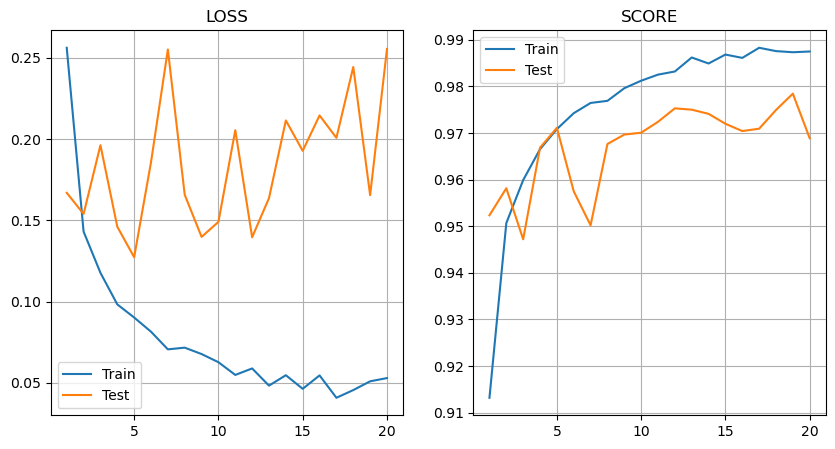

In [144]:
th=len(score_history[1])
fg,axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(1,th+1),loss_history[0][:th],label='Train')
axes[0].plot(range(1,th+1),loss_history[1][:th],label='Test')
axes[0].set_title('LOSS')
axes[0].grid()
axes[0].legend()

axes[1].plot(range(1,th+1),score_history[0][:th],label='Train')
axes[1].plot(range(1,th+1),score_history[1][:th],label='Test')
axes[1].set_title('SCORE')
axes[1].grid()
axes[1].legend()

plt.show()